In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers.convolutional import Conv1D,MaxPooling1D
import tensorflow_decision_forests as tfdf
from IPython.display import clear_output
clear_output()

The above cell is used to import the packages needed for the project

In [128]:
electricity_df=pd.read_csv('LD2011_2014.txt',delimiter=';',low_memory=False)
electricity_df.head()

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


As we can see above,the dataset consists of a timestamp column,and 370 columns,with each one corresponding to one client that returns power consumption readings.

In [129]:
column_names=electricity_df.columns.to_list()
#REPLACING COMMA WITH DOT SO THAT THE NUMBERS PRESENT AS 9.3 AND NOT 9,3
for i in range(1,len(column_names)):
    if(electricity_df[column_names[i]].dtype==object):
        electricity_df[column_names[i]]=electricity_df[column_names[i]].str.replace(',','.')

#CONVERTING NUMERICAL VALUES FROM STRING TO FLOAT
for i in range(1,len(column_names)):
    electricity_df[column_names[i]]=electricity_df[column_names[i]].astype(float)

#DIVIDING EACH NUMERICAL COLUMN BY 4 AND ROUNDING TO 3 DECIMALS
for i in range(1,len(column_names)):
    electricity_df[column_names[i]]=electricity_df[column_names[i]].div(4).round(3)




The above code converts all numerical values to floats.Afterwards it changes the unit of measurement used.<br>
The original measurement was KW per 15 minutes.We divided this value by 4 in order to have the units as KWh.

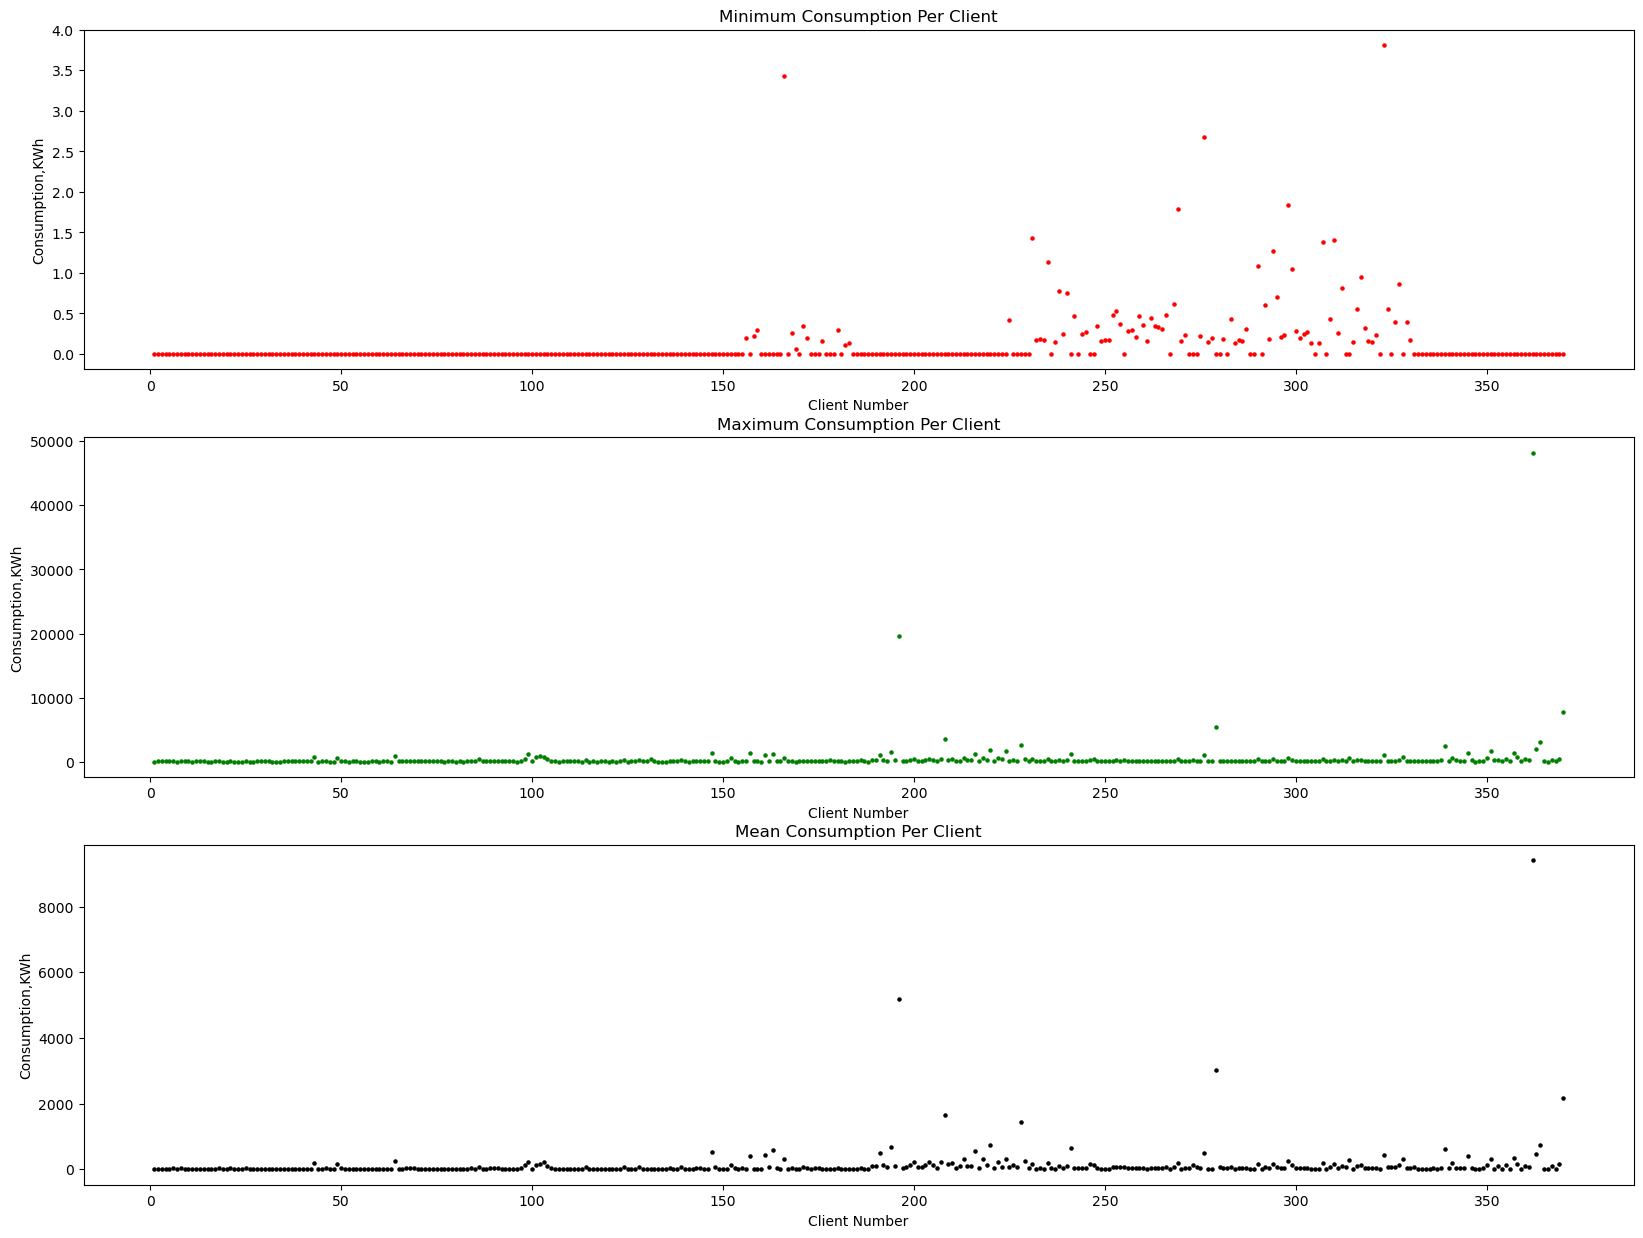

In [130]:
min=[]
max=[]
avg=[]
cl_num=[]
for i in range(1,len(column_names)):
    if((electricity_df[column_names[i]]!=0).sum()>0):
        min.append(electricity_df[column_names[i]].min())
        max.append(electricity_df[column_names[i]].max())
        avg.append(electricity_df[column_names[i]].mean())
    else:
        #PERFORMING PADDING
        min.append(0)
        max.append(0)
        avg.append(0)
    cl_num.append(i)

min=np.array(min)
max=np.array(max)
avg=np.array(avg)
cl_num=np.array(cl_num)

plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.title("Minimum Consumption Per Client")
plt.scatter(cl_num,min,c='red',s=5)
plt.xlabel("Client Number")
plt.ylabel("Consumption,KWh")
plt.subplot(3,1,2)
plt.title("Maximum Consumption Per Client")
plt.scatter(cl_num,max,c='green',s=5)
plt.xlabel("Client Number")
plt.ylabel("Consumption,KWh")
plt.subplot(3,1,3)
plt.title("Mean Consumption Per Client")
plt.scatter(cl_num,avg,c='black',s=5)
plt.xlabel("Client Number")
plt.ylabel("Consumption,KWh")
#plt.savefig('per_client_stats')
plt.show()



The above graph shows the minimum,maximum and mean consumption of each client,based on non zero columns.<br>
We chose to ommit zero recordings because it means there has not been a recording on that timestamp.<br>
Because the Clients are both small Companies and Industrial/Public infrastructure clients the gaps are very large between client consumptions.<br>
This happens because a home user almost certainly will not consume a KWh or more during 15 minutes,but a factory might need that much power.

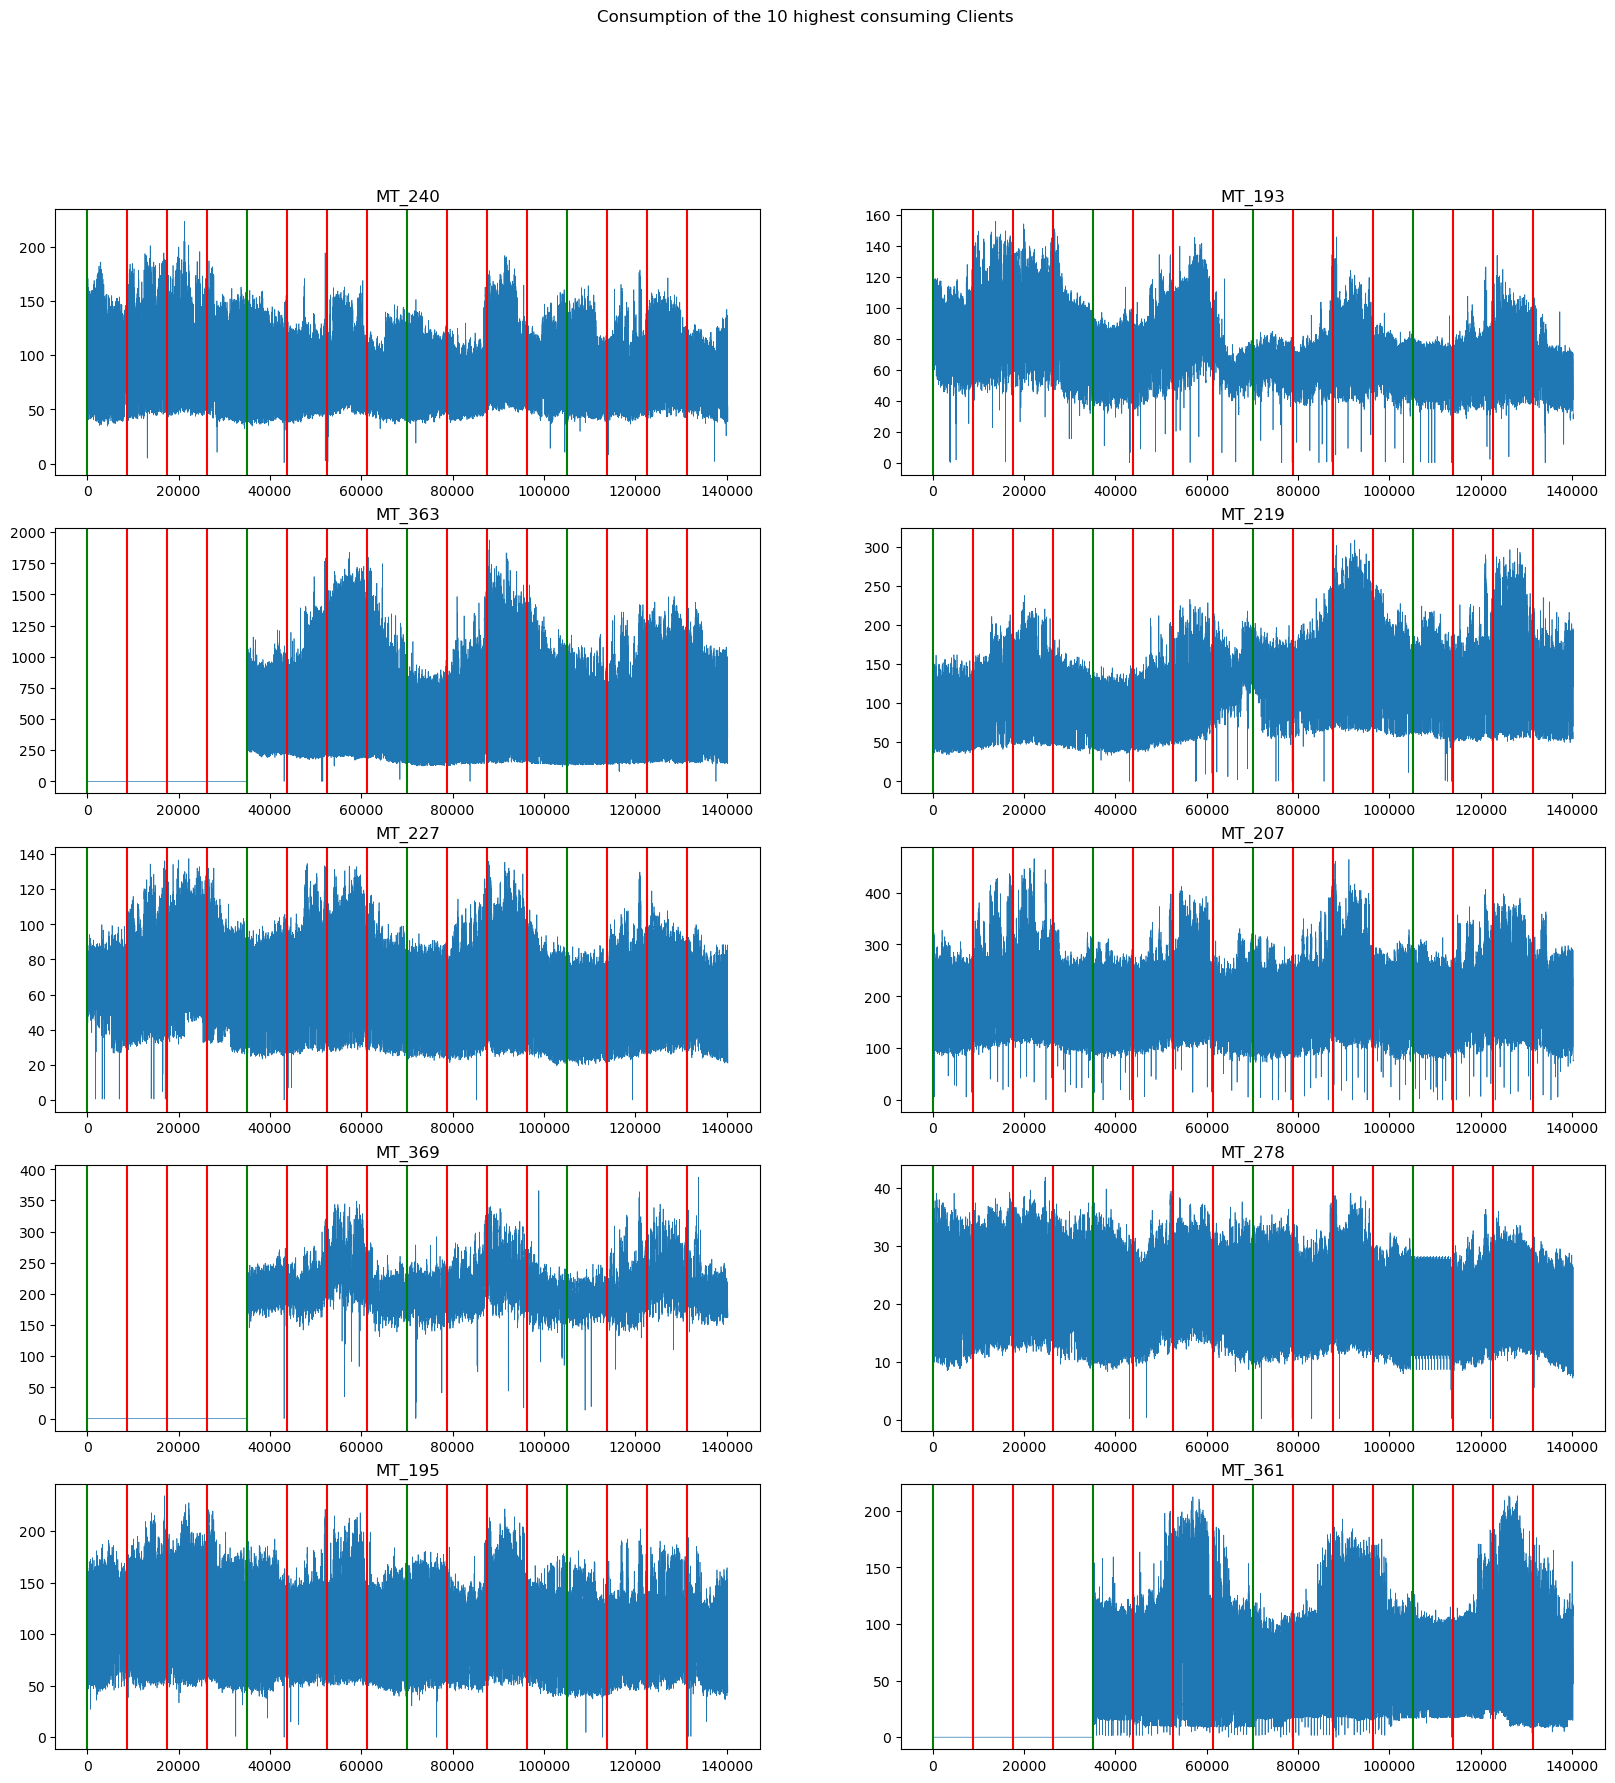

In [131]:
top_10=np.argsort(avg)[-10:]
year=4*24*365
season=year/4
plt.figure(figsize=(20,20))
plt.suptitle('Consumption of the 10 highest consuming Clients')
for i in range(0,len(top_10)):
    plt.subplot(5,2,i+1)
    plt.title(column_names[top_10[i]])
    plt.plot(electricity_df[column_names[top_10[i]]],linewidth=0.5)
    for i in range(0,4):
        plt.axvline(x=year*i,ymin=0,color='green')
        for j in range(1,4):
            plt.axvline(x=season*j+year*i,ymin=0,color='red')
#plt.savefig('avg_consumption')


The above graphs show the consumption of each one of the top 10 highest consuming stations.Each green line signals the end of a year,each red one represents a season change.<br>
We can see that within a year there is a seasonality,where in most cases the energy consumption increases during the year,with the yearly maximum to be located in the third quarter of the year that is the summer.<br>This graph also shows that some Clients were not being recorded the first year,something that was mentioned in the Dataset description.

In [132]:
consumption_array=electricity_df[column_names[1:]].to_numpy()
consumption_array=np.transpose(consumption_array)
print(consumption_array.shape)
consumption_array=consumption_array[:,24*4*365:]
print(consumption_array.shape)

(370, 140256)
(370, 105216)


In order to perform a dimension reduction,we must shape the array in a way that the dimension to be reduced is the column dimension of the array.<br>
We remove the first year of samples,in order to have a consistency among the timeseries,so that there are no padded data.

In [133]:
scaler=StandardScaler()
scaled_con=scaler.fit_transform(consumption_array)

We scale the values in order to perform the principal component analysis (PCA)

In [134]:
pca=PCA(n_components=100)
principal_components=pca.fit_transform(scaled_con)
pcdf=pd.DataFrame(data=principal_components)
print(pcdf.shape)

(370, 100)


As we can see after the analysis we have 370 vectors,each one containing 100 features.

In [135]:
pcdf=pcdf.to_numpy()
#8 CLUSTERS PROVIDED BY THE SCENARIO,10 REPETITIONS OF THE ALGORITHM
kmeans=KMeans(n_clusters=8,random_state=0,n_init=10).fit(pcdf)
count=np.array([0,0,0,0,0,0,0,0])
for i in kmeans.labels_:
    count[i]+=1
print("Samples assigned to each centroid: ",count)


Samples assigned to each centroid:  [301   1   1  15   1   1  48   2]


As we can see above,the 8 centroids have some values assigned to them,but the number of samples assigned to each centroid show imbalances.

First sample of given category:  [0, 361, 278, 146, 369, 195, 42, 207]


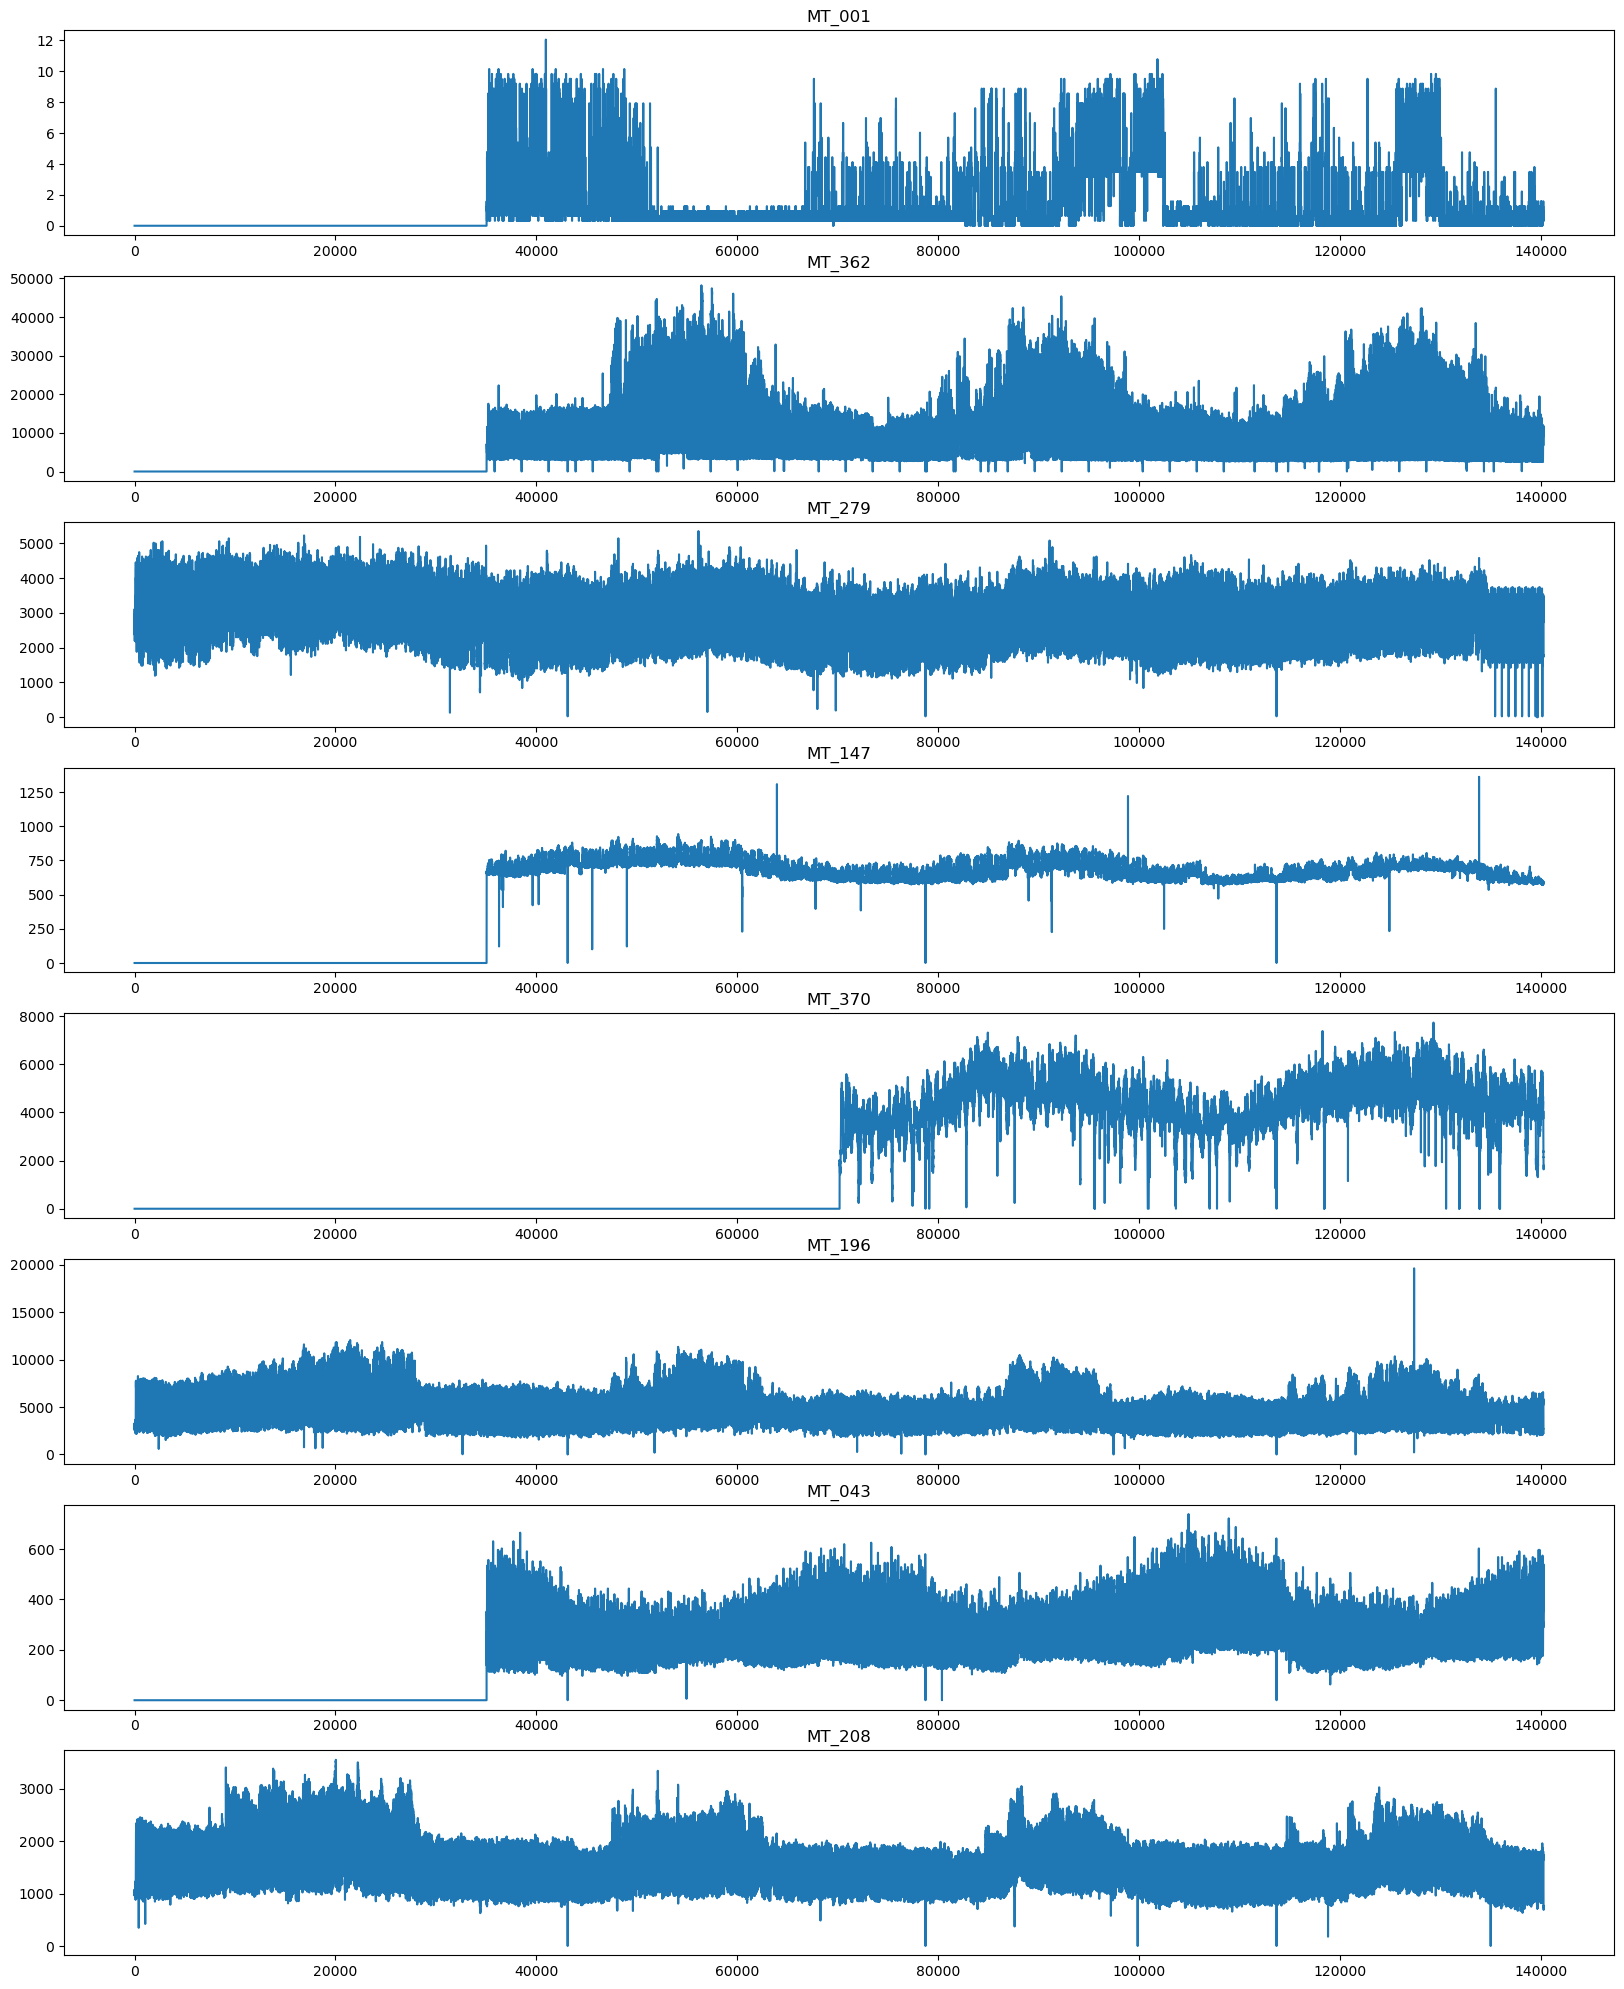

In [136]:
positions=[]
for i in range(0,8):
    positions.append(np.where(kmeans.labels_==i)[0][0])
print("First sample of given category: ",positions)
plt.figure(figsize=(20,25))
j=1
for i in positions:
    plt.subplot(8,1,j)
    plt.plot(electricity_df[column_names[i+1]])
    plt.title(column_names[i+1])
    j+=1
#plt.savefig('centroids')
plt.show()

The above graph shows,one timeseries for each centroid produced by the K-Means algorithm.<br>
We can see that each timeseries has different trend and seasonality and even timeseries that at first glance look similar,have very different unit scales.

In [137]:
pca=PCA(n_components=10)
principal_components=pca.fit_transform(scaled_con)
out=pd.DataFrame(data=principal_components).to_numpy()
print(out.shape)

(370, 10)


For the DBSCAN process,we will reduce the timeseries down to 10 samples.<br>
Because it is a density based algorithm,we will try different combination of cluster distances and minimum samples in order to find the best one.

In [138]:
labels=[]
label_count=[]
params=[]
#IT SERVES NO PURPOSE TO HAVE CLUSTERS WITH 0 OR 1 OBJECTS
for samples in range(2,6):
    for eps in range(5,15):
        dbscan=DBSCAN(eps=eps/10,min_samples=samples).fit(out)
        labels.append(dbscan.labels_)
        label_count.append(np.unique(dbscan.labels_))
        params.append([samples,eps/10])
for i in range(0,len(label_count)):
    print("Number of Labels: ",label_count[i]," With Parameters: ",params[i])

Number of Labels:  [-1  0  1  2  3  4  5  6  7  8  9]  With Parameters:  [2, 0.5]
Number of Labels:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]  With Parameters:  [2, 0.6]
Number of Labels:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]  With Parameters:  [2, 0.7]
Number of Labels:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]  With Parameters:  [2, 0.8]
Number of Labels:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]  With Parameters:  [2, 0.9]
Number of Labels:  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]  With Parameters:  [2, 1.0]
Number of Labels:  [-1  0  1  2  3  4  5  6  7  8  9]  With Parameters:  [2, 1.1]
Number of Labels:  [-1  0  1  2  3  4  5]  With Parameters:  [2, 1.2]
Number of Labels:  [-1  0  1  2  3  4  5  6]  With Parameters:  [2, 1.3]
Number of Labels:  [-1  0  1  2  3  4  5  6  7  8  9]  With Parameters:  [2, 1.4]
Number of Labels:  [-1  0  1  2  3  4]  With Parameters:  [3, 0.5]
Number of Labels:  [-1  0  1  2  3  4]  With Parameters:  [3, 0.6]
Number of Labels

As we can see above,the higher the higher distance margin produces less clusters,and also less samples per cluster produces less clusters.<br>
For the analysis needed we will work with an example that is somewhere in between.<br>
The parameters used will be 3 samples per cluster and the maximum allowed distance will be 1,1.

In [139]:
dbscan=DBSCAN(eps=1.1,min_samples=3).fit(out)
unassigned=0
count=[]
for i in range(0,8):
    count.append(0)
for i in dbscan.labels_:
    if(i!=-1):
        count[i]+=1
    else:
        unassigned+=1
print('Samples assigned to each cluster: ',count)
print('Unassigned Samples: ',unassigned)

Samples assigned to each cluster:  [73, 7, 5, 5, 20, 4, 3, 5]
Unassigned Samples:  248


As we can see from the above output,DBSCAN does not classify each timeseries to a cluster,because it uses density based characteristics,rather than eucledian distance.<br>
This means that it leaves many timeseries unassigned due to them not really fitting to any category.That is the main difference with the k-means algorithm.<br>
This happens because k-means assigns to the shortest distance.In DBSCAN it is possible for a sample to not be "close" enough to be classified to a cluster.

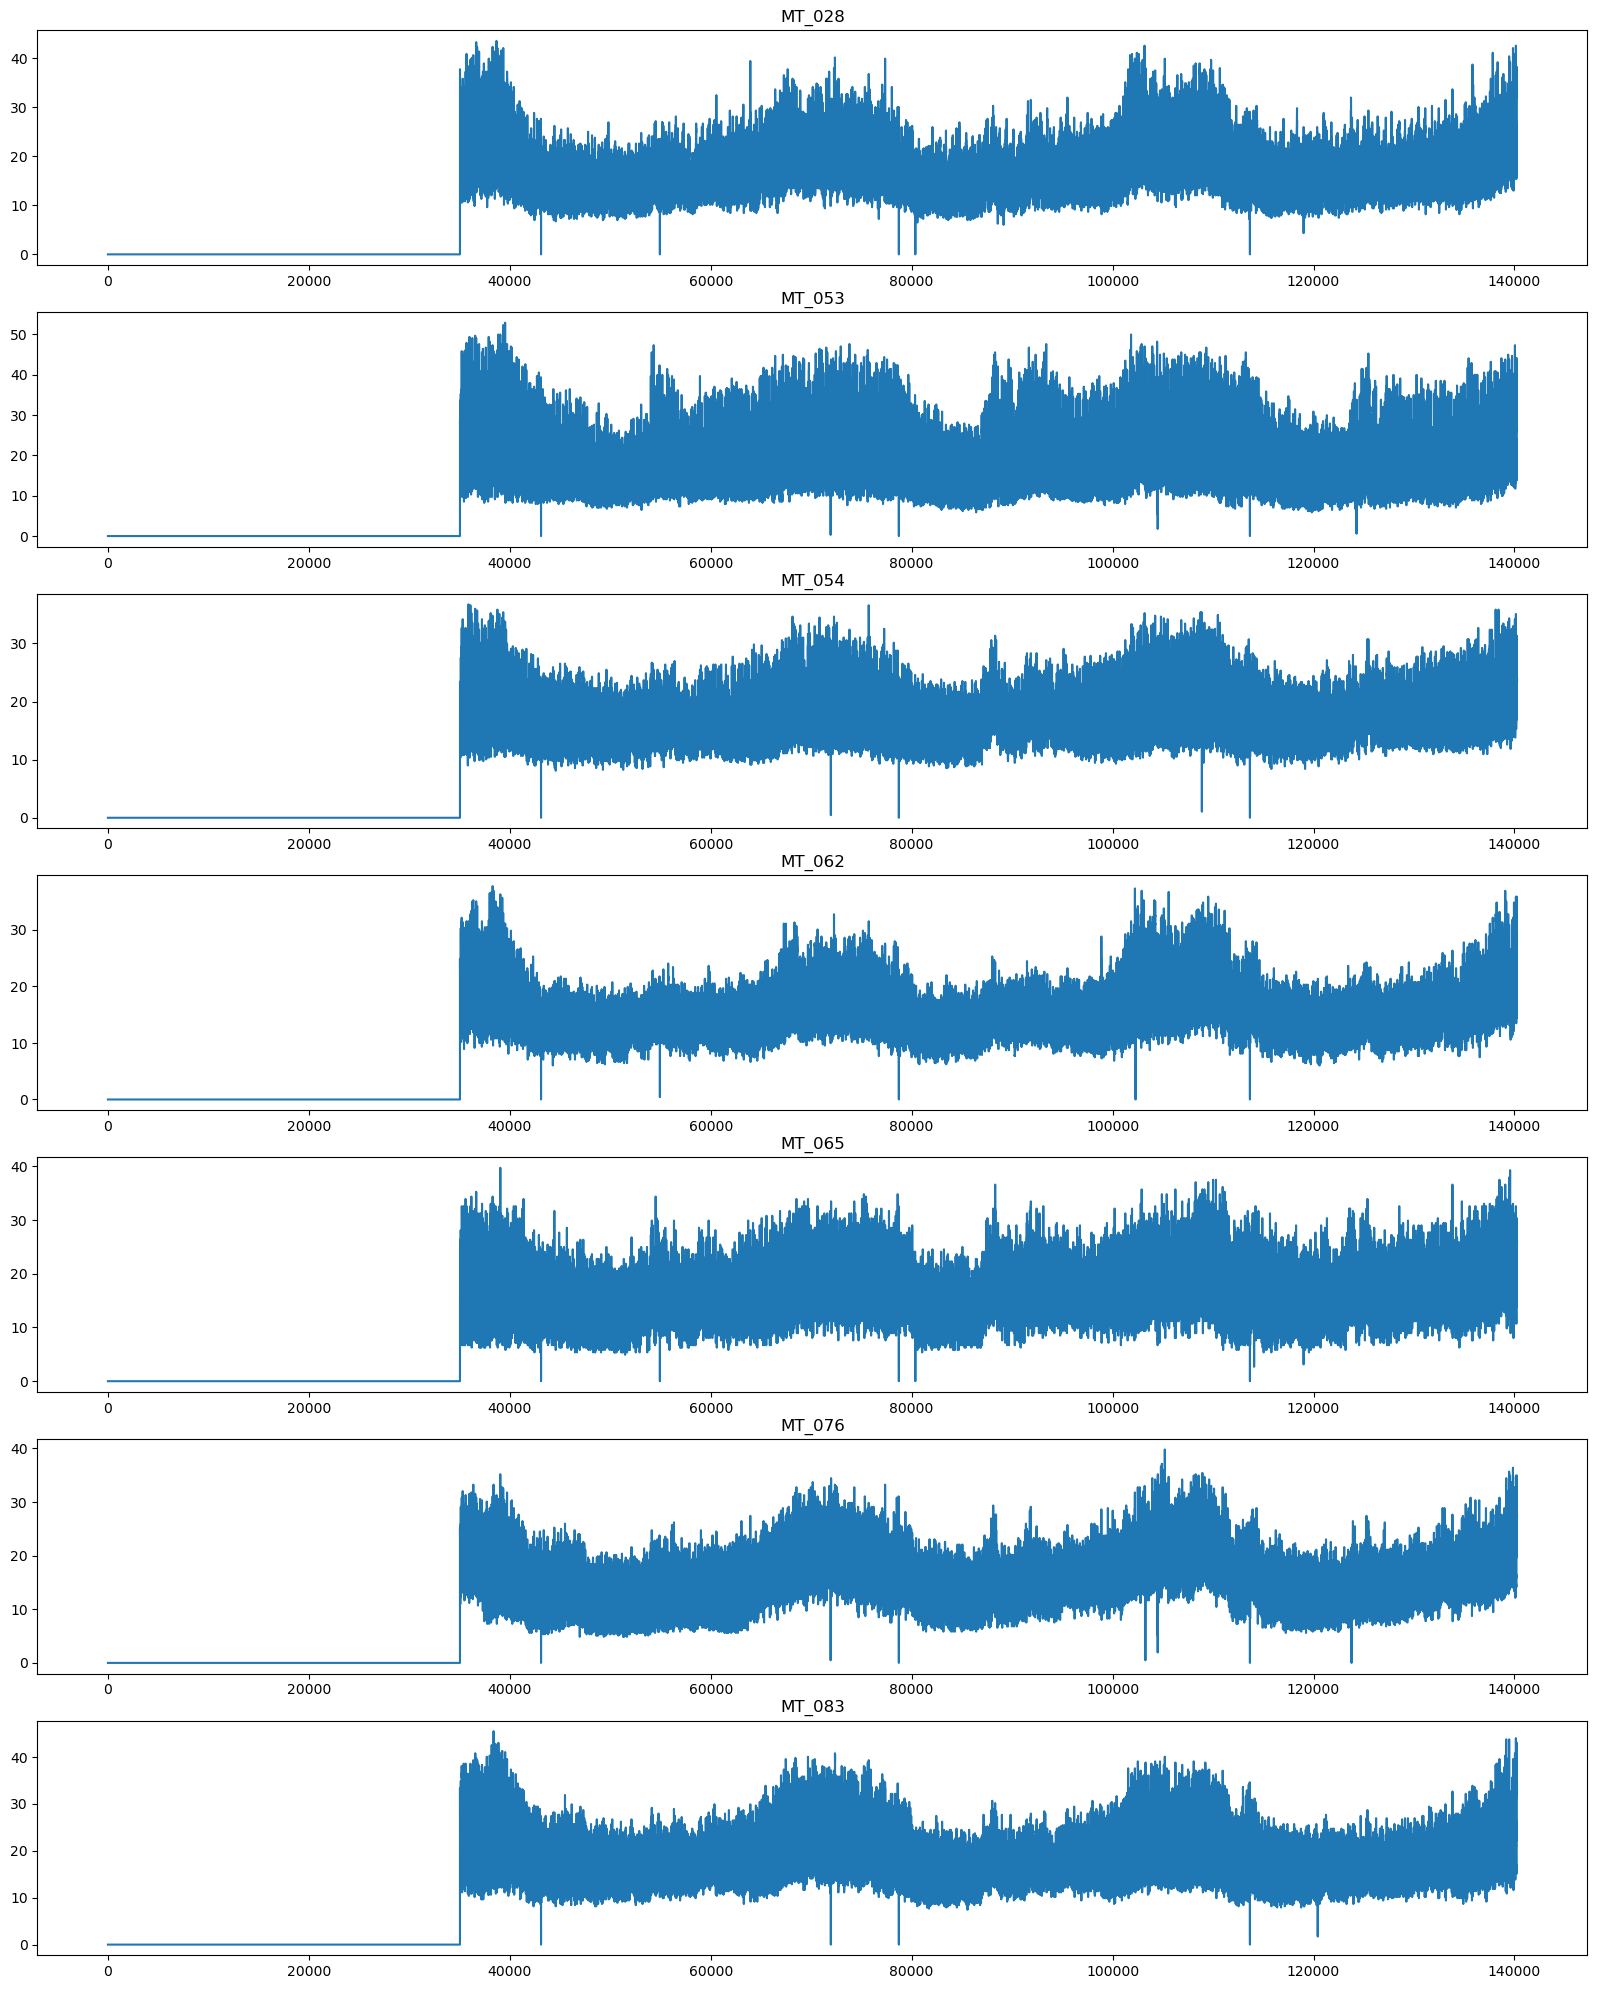

In [140]:
positions=[]
for i in range(0,len(dbscan.labels_)):
    if(dbscan.labels_[i]==1):
        positions.append(i)
plt.figure(figsize=(20,25))
j=1
for i in positions:
    plt.subplot(7,1,j)
    j+=1
    plt.plot(electricity_df[column_names[i+1]])
    plt.title(column_names[i+1])
#plt.savefig('dbscan_cluster')
plt.show()

The above graph shows,all members of a cluster created by DBSCAN.As we can see there is very little difference between all timeseries.<br>
This proves that DBSCAN assignes to a cluster only when the samples are similar enough,rather than the most similar,
without taking into account that they might not be similar enough to be grouped together.

In [141]:
from datetime import datetime
p=[]
for i in range(0,len(dbscan.labels_)):
    if(dbscan.labels_[i]==4):
        p.append(i)
print("Timeseries used for prediction(cluster number 4): ")
target_df=pd.DataFrame()
target_df['timestamp']=electricity_df[column_names[0]]
for i in p:
    target_df[column_names[i+1]]=electricity_df[column_names[i+1]]
datetimes=target_df.timestamp.to_numpy()
timestamps=[]
for i in datetimes:
    timestamps.append(datetime.strptime(i,'%Y-%m-%d %H:%M:%S'))
target_df.timestamp=pd.DataFrame(timestamps)
for i in p:
    print(column_names[i+1],end=' ')

target_df.head()

Timeseries used for prediction(cluster number 4): 
MT_151 MT_176 MT_183 MT_230 MT_232 MT_234 MT_237 MT_250 MT_251 MT_277 MT_278 MT_285 MT_291 MT_293 MT_296 MT_306 MT_315 MT_319 MT_320 MT_330 

,timestamp,MT_151,MT_176,MT_183,MT_230,MT_232,MT_234,MT_237,MT_250,MT_251,...,MT_278,MT_285,MT_291,MT_293,MT_296,MT_306,MT_315,MT_319,MT_320,MT_330
0,2011-01-01 00:15:00,0.0,10.371,11.429,15.555,14.537,9.527,13.519,11.672,14.073,...,12.349,13.449,20.924,18.551,11.971,9.186,18.154,11.834,15.630,11.270
1,2011-01-01 00:30:00,0.0,9.873,10.688,15.415,13.999,10.093,11.176,12.159,14.475,...,12.717,13.449,21.332,18.264,12.643,9.824,17.199,12.277,14.654,12.522
2,2011-01-01 00:45:00,0.0,10.619,10.688,14.714,14.940,10.518,13.106,12.482,12.201,...,12.349,14.279,22.962,17.116,12.475,9.059,16.617,11.391,15.212,10.489
3,2011-01-01 01:00:00,0.0,10.868,10.133,15.555,13.596,8.960,12.417,12.806,10.865,...,11.981,13.726,20.516,18.408,13.316,8.549,16.617,11.686,14.794,11.270
4,2011-01-01 01:15:00,0.0,10.122,9.763,15.135,14.805,8.535,14.485,12.806,10.462,...,11.797,12.066,21.739,17.834,11.971,9.059,15.256,11.686,14.654,11.270


The above dataframe will be used for the prediction performed afterwards.

In [142]:
short_df=pd.DataFrame()
long_df=pd.DataFrame()
columns=target_df.columns
for i in range(1,len(columns)):
    col=target_df[columns[i]].to_numpy()
    s=[]
    #3 hours,4 samples per hour
    for j in range(0,len(col),3*4):
        s.append(sum(col[j:j+3*4]))
    short_df[columns[i]]=pd.DataFrame(s)
    l=[]
    #3 days,24 hours a day,4 samples an hour
    for j in range(0,len(col),3*4*24):
        l.append(sum(col[j:j+3*4*24]))
    long_df[columns[i]]=pd.DataFrame(l)
print("Number of samples of each time series(short term): ",short_df.shape[0])
print("Number of samples of each time series(long term): ",long_df.shape[0])




Number of samples of each time series(short term):  11688
Number of samples of each time series(long term):  487


The above data frames are the datasets for the short term and long term analysis respectively.<br>
Each sample is the sum of the consumption for the given period of time.<br>
Short Term:4 * 3=12 Samples,Long Term:3 * 24 * 4=288 Samples

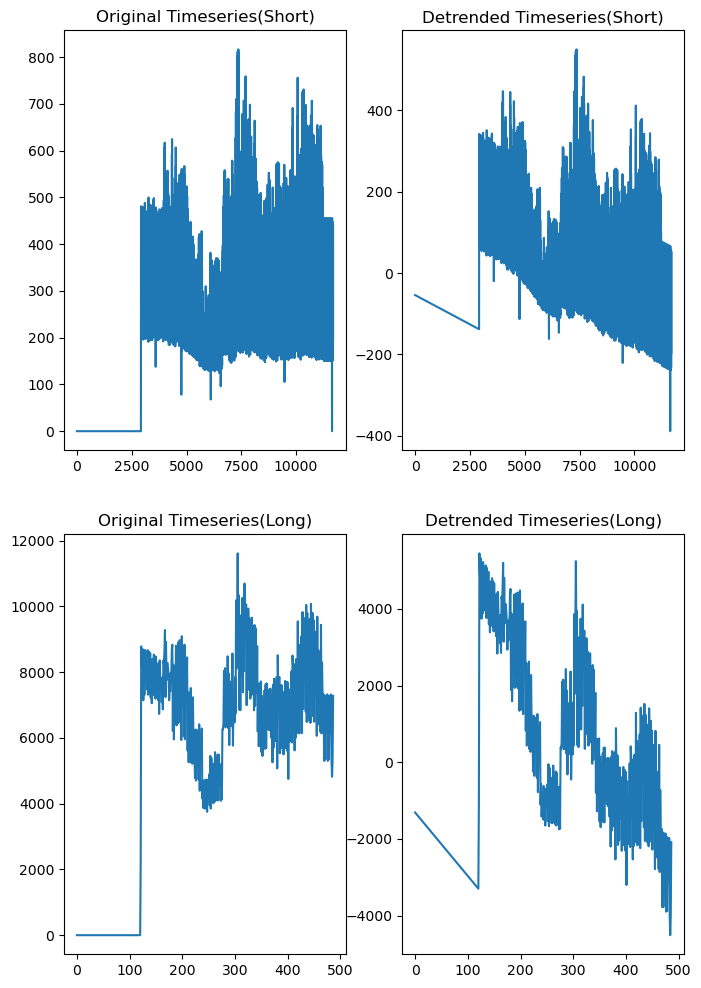

In [143]:
short_det=pd.DataFrame()
long_det=pd.DataFrame()
for i in range(1,len(columns)):
    short_det[columns[i]]=pd.DataFrame(signal.detrend(short_df[columns[i]].values))
    long_det[columns[i]]=pd.DataFrame(signal.detrend(long_df[columns[i]].values))
plt.figure(figsize=(8,12))
plt.subplot(2,2,1)
plt.title('Original Timeseries(Short)')
plt.plot(short_df[columns[1]])
plt.subplot(2,2,2)
plt.title('Detrended Timeseries(Short)')
plt.plot(short_det[columns[1]])
plt.subplot(2,2,3)
plt.title('Original Timeseries(Long)')
plt.plot(long_df[columns[1]])
plt.subplot(2,2,4)
plt.title('Detrended Timeseries(Long)')
plt.plot(long_det[columns[1]])
#plt.savefig('detrended')
short_df=short_det
long_df=long_det
del short_det,long_det



Having detrended the timeseries we will now remove seasonality.<br>
Above we can see the detrended Short-Term and Long-Term  timeseries of the second sample.

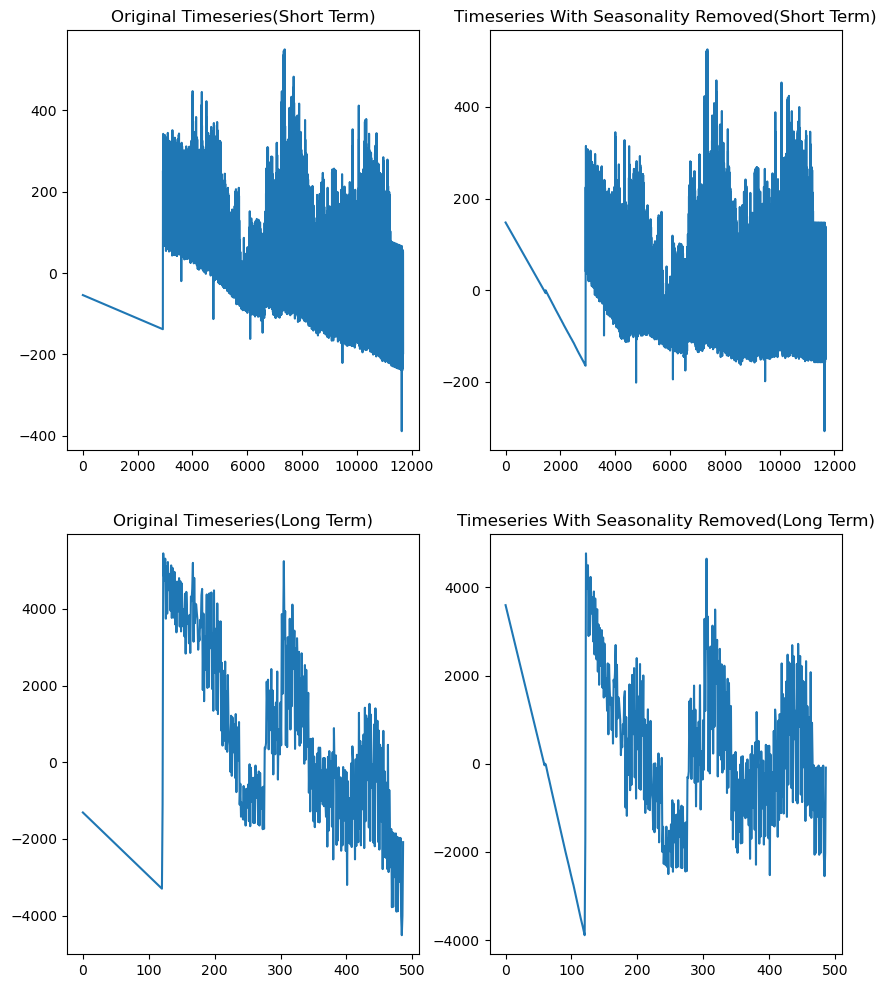

In [144]:
short=pd.DataFrame()
long=pd.DataFrame()
for i in range(1,len(columns)):
    #seasonality occurs through the course of a year,so we remove it accordingly
    res=seasonal_decompose(short_df[columns[i]],model='additive',extrapolate_trend='freq',period=int(short_df[columns[i]].shape[0]/4))
    short[columns[i]]=pd.DataFrame(short_df[columns[i]].values-res.trend)
    res=seasonal_decompose(long_df[columns[i]],model='additive',extrapolate_trend='freq',period=int(long_df[columns[i]].shape[0]/4))
    long[columns[i]]=pd.DataFrame(long_df[columns[i]].values-res.trend)
plt.figure(figsize=(10,12))
plt.subplot(2,2,1)
plt.title('Original Timeseries(Short Term)')
plt.plot(short_df[columns[1]])
plt.subplot(2,2,2)
plt.title('Timeseries With Seasonality Removed(Short Term)')
plt.plot(short[columns[1]])
plt.subplot(2,2,3)
plt.title('Original Timeseries(Long Term)')
plt.plot(long_df[columns[1]])
plt.subplot(2,2,4)
plt.title('Timeseries With Seasonality Removed(Long Term)')
plt.plot(long[columns[1]])
#plt.savefig('seasonality')
short_df=short
long_df=long
del short,long

In [145]:
scaler=MinMaxScaler()

for i in range(1,len(columns)):
    short_df[columns[i]]=pd.DataFrame(scaler.fit_transform(short_df[columns[i]].to_numpy().reshape(-1,1)))
    long_df[columns[i]]=pd.DataFrame(scaler.fit_transform(long_df[columns[i]].to_numpy().reshape(-1,1)))
print("Short term Timeseries\n",short_df.head())
print("\n\nLong term Timeseries\n",long_df)

Short term Timeseries
      MT_151    MT_176    MT_183    MT_230    MT_232    MT_234    MT_237  \
0  0.546572  0.047714  0.046495  0.093024  0.092754  0.063913  0.290586   
1  0.546445  0.052395  0.046048  0.121676  0.059571  0.074444  0.285143   
2  0.546318  0.071848  0.097615  0.148517  0.095854  0.090792  0.289159   
3  0.546192  0.306897  0.105894  0.153424  0.256639  0.096060  0.295755   
4  0.546065  0.270942  0.080546  0.141305  0.255444  0.107433  0.296617   

     MT_250    MT_251    MT_277    MT_278    MT_285    MT_291    MT_293  \
0  0.081753  0.123731  0.066585  0.083578  0.045176  0.257609  0.187821   
1  0.078710  0.090041  0.063360  0.083092  0.056471  0.246984  0.181673   
2  0.070436  0.313060  0.038302  0.102738  0.082787  0.251753  0.240197   
3  0.085709  0.400875  0.079638  0.094695  0.175279  0.239642  0.349469   
4  0.101431  0.392021  0.092645  0.086644  0.186229  0.198224  0.308350   

     MT_296    MT_306    MT_315    MT_319    MT_320    MT_330  
0  0.009330

We have scaled the timeseries with the Standard Scaler.<br>The Scaling has been performed columnwise in order to preserve the scale of each timeseries.<br>
This approach has been chosen because most timeseries have different Units.

In [146]:
short_flags=pd.DataFrame()
long_flags=pd.DataFrame()
for i in range(1,len(columns)):
    s=[0]
    for j in range(1,len(short_df[columns[i]])):
        sign=np.sign(short_df[columns[i]][j]-short_df[columns[i]][j-1])
        s.append(sign)

    s=np.array(s)
    short_flags[columns[i]]=pd.DataFrame(s)
    s=[0]
    for j in range(1,len(long_df[columns[i]])):
        sign=np.sign(short_df[columns[i]][j]-short_df[columns[i]][j-1])
        s.append(sign)
    s=np.array(s)
    long_flags[columns[i]]=pd.DataFrame(s)


The above block of code creates a new timeseries for each existing one that consists of the difference in consumption between intervals of the initial timeseries.<br>
This timeseries consists of flags,-1 for power decrease and 1 for power increase.

In [147]:
def split_sequence(sequence,n_steps):
    sequence=sequence.to_numpy()
    s=[]
    for i in range(0,len(sequence)-n_steps):
        s.append(sequence[i:i+n_steps].tolist())
    s=np.array(s)
    return s

This function creates the window sized samples used in the CNN model bellow.

In [148]:
models_short=[]
accuracy_short=[]
mape_short=[]
for i in range(1,len(columns)):
    model=Sequential()
    model.add(Conv1D(filters=64,kernel_size=2,activation='relu',input_shape=(3,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')
    x=split_sequence(short_df[columns[i]],3)
    x=x.reshape((x.shape[0],x.shape[1],1))
    y=short_flags[columns[i]].to_numpy()
    Y=y[3:]
    xtrain,xtest,ytrain,ytest=train_test_split(x,Y,test_size=0.1)
    model.fit(xtrain,ytrain,epochs=10,verbose=0)
    models_short.append(model)
    accuracy_short.append(model.evaluate(xtest,ytest,verbose=0))
    ypred=model.predict(xtest,verbose=0)
    mape_short.append(mean_absolute_percentage_error(ytest,ypred))
    #CREATING NEW MODEL FOR NEXT TRAINING ROUND
    del model

clear_output()
print("Loss of Each Model:")
print(accuracy_short)
print("Mean Absolute Percentage Error:")
print(mape_short)


Loss of Each Model:
[0.6329182982444763, 0.5529990792274475, 0.6193323731422424, 0.6490659713745117, 0.5384333729743958, 0.5091200470924377, 0.5573219060897827, 0.46968787908554077, 0.5286440253257751, 0.4952421188354492, 0.42264461517333984, 0.6142523884773254, 0.49675172567367554, 0.45335933566093445, 0.5124865770339966, 0.6211966276168823, 0.6981724500656128, 0.5916768312454224, 0.5719881057739258, 0.5759251713752747]
Mean Absolute Percentage Error:
[0.6593495301322309, 0.5940963953822672, 0.6556551749885745, 0.6880060575473846, 0.5889738731793709, 0.5505595674325606, 0.5858823736736007, 0.5369639181897643, 0.5643009760244164, 0.5519021385507873, 0.4565217345283774, 0.651125180835368, 0.5529542663556877, 0.49682133081086277, 0.5736276477390472, 0.6403951916534539, 0.7274922023123406, 0.6241809099441007, 0.6151290107502501, 0.6431715768738829]


In [149]:
models_long=[]
accuracy_long=[]
mape_long=[]
for i in range(1,len(columns)):
    model=Sequential()
    model.add(Conv1D(filters=64,kernel_size=2,activation='relu',input_shape=(3,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')
    x=split_sequence(long_df[columns[i]],3)
    x=x.reshape((x.shape[0],x.shape[1],1))
    y=long_flags[columns[i]].to_numpy()
    Y=y[3:]
    xtrain,xtest,ytrain,ytest=train_test_split(x,Y,test_size=0.1)
    model.fit(xtrain,ytrain,epochs=10,verbose=0)
    models_long.append(model)
    accuracy_long.append(model.evaluate(xtest,ytest,verbose=0))
    ypred=model.predict(xtest,verbose=0)
    mape_long.append(mean_absolute_percentage_error(ytest,ypred))
    #CREATING NEW MODEL FOR NEXT TRAINING ROUND
    del model

clear_output()
print("Loss of Each Model:")
print(accuracy_long)
print("Mean Absolute Percentage Error:")
print(mape_long)


Loss of Each Model:
[0.02493753656744957, 0.850739598274231, 1.0397448539733887, 0.9090790748596191, 1.0392521619796753, 1.0569422245025635, 0.9672317504882812, 0.9845064878463745, 1.0030629634857178, 0.9696006178855896, 0.9743947386741638, 0.9612687826156616, 1.0087976455688477, 0.9949331283569336, 0.7795862555503845, 1.068520188331604, 1.0078994035720825, 1.024339199066162, 1.0014711618423462, 0.9999263286590576]
Mean Absolute Percentage Error:
[0.12711771410338732, 0.8972619054268818, 1.0099653057297882, 0.9397995541898572, 1.014160092235828, 1.0134129873952087, 0.9530646813159086, 0.9901583910140456, 1.0011029621700243, 0.980260927762304, 0.9632352830804124, 0.9781686235599372, 0.9943743554913268, 0.9831577542485023, 0.848446216814372, 1.0023372617303108, 1.0013508938100872, 1.011414016730019, 0.9994962749888703, 0.9989483086582349]


The above blocks of code create and train a CNN model for each timeseries with a window of 3 samples.<br>
After the execution of each block of code,we can see the Loss for each model and the MAPE metric.

In [150]:
forest_models_short=[]
forest_mse_short=[]
for i in range(1,len(columns)):
    tensor_in=short_df[columns[i]].to_numpy()
    tensor_out=[0]
    for i in range(1,len(tensor_in)):
        tensor_out.append(tensor_in[i-1]-tensor_in[i])
    tensor_in=np.array(tensor_in)
    tensor_out=np.array(tensor_out)
    xtrain,xtest,ytrain,ytest=train_test_split(tensor_in,tensor_out,test_size=0.1)


    model=tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION,verbose=0)

    model.fit(x=xtrain,y=ytrain,verbose=0)
    model.compile(metrics=["mse"])

    out=model.evaluate(x=xtest,y=ytest,return_dict=True,verbose=0)
    forest_models_short.append(model)
    forest_mse_short.append(out['mse'])

clear_output()
print('Mean Square Error of each Model(Short Time Analysis): ')
print(forest_mse_short)

Mean Square Error of each Model(Short Time Analysis): 
[0.008131631650030613, 0.022996006533503532, 0.02716008760035038, 0.012849986553192139, 0.02102033421397209, 0.01481795497238636, 0.010148676112294197, 0.02169700711965561, 0.028388598933815956, 0.01633848063647747, 0.027140622958540916, 0.0279085673391819, 0.01989206112921238, 0.03279479593038559, 0.013083692640066147, 0.015719879418611526, 0.018966421484947205, 0.023829691112041473, 0.013073600828647614, 0.018702637404203415]


In [151]:
forest_models_long=[]
forest_mse_long=[]
for i in range(1,len(columns)):
    tensor_in=long_df[columns[i]].to_numpy()
    tensor_out=[0]
    for i in range(1,len(tensor_in)):
        tensor_out.append(tensor_in[i-1]-tensor_in[i])
    tensor_in=np.array(tensor_in)
    tensor_out=np.array(tensor_out)
    xtrain,xtest,ytrain,ytest=train_test_split(tensor_in,tensor_out,test_size=0.1)


    model=tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION,verbose=0)

    model.fit(x=xtrain,y=ytrain,verbose=0)
    model.compile(metrics=["mse"])

    out=model.evaluate(x=xtest,y=ytest,return_dict=True,verbose=0)
    forest_models_long.append(model)
    forest_mse_long.append(out['mse'])

clear_output()
print('Mean Square Error of each Model(Long Time Analysis): ')
print(forest_mse_long)

Mean Square Error of each Model(Long Time Analysis): 
[0.024074364453554153, 0.013607071712613106, 0.017113428562879562, 0.007560609374195337, 0.006613390985876322, 0.00682420190423727, 0.013861166313290596, 0.008249178528785706, 0.00877896137535572, 0.005091020837426186, 0.008924215100705624, 0.006867749150842428, 0.012695672921836376, 0.015314579010009766, 0.0038546768482774496, 0.007989191450178623, 0.003700630972161889, 0.003712650155648589, 0.00671731773763895, 0.005245804321020842]


The above blocks of code create and train a Random Forest Regression for each timeseries and print the MSE(Mean Square Error) metric for each model.

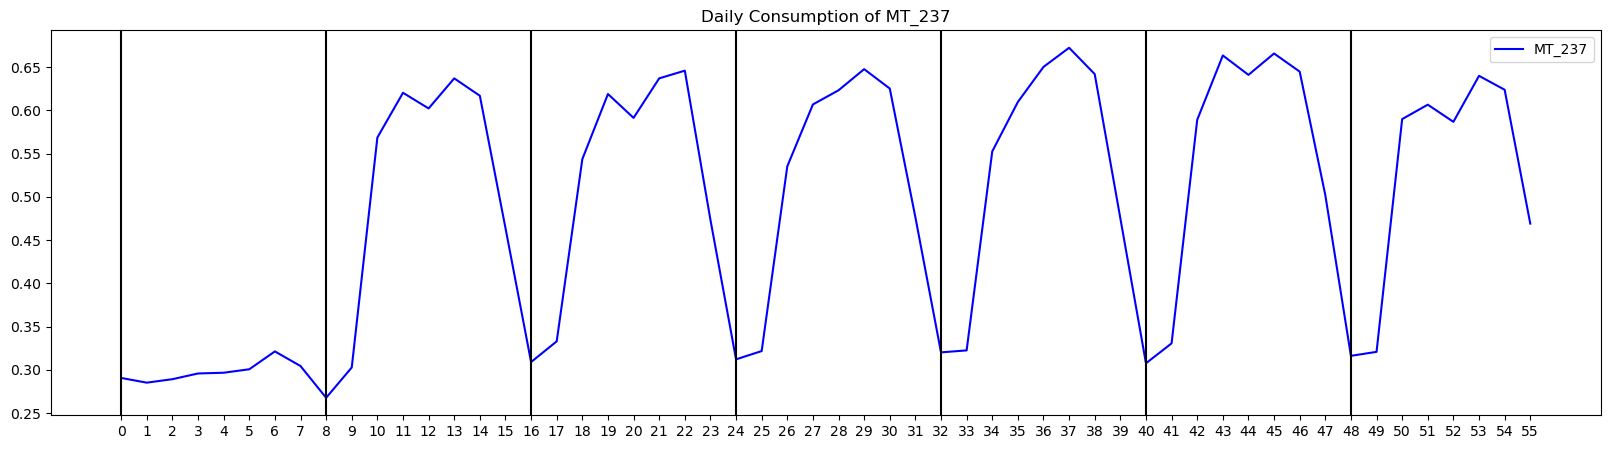

In [152]:
timeseries1,timeseries2=short_df[columns[6]].to_numpy(),short_df[columns[7]].to_numpy()
plt.figure(figsize=(20,5))
#plt.plot(timeseries1[0:8*7],label=columns[6],c='orange')
plt.plot(timeseries2[0:8*7],label=columns[7],c='blue')
plt.title('Daily Consumption of '+columns[7])
r=np.arange(0,8*7)
plt.xticks(r)
for i in range(0,8*7,8):
    plt.axvline(x=i,color='black')
plt.legend()
#plt.savefig('consumption')
plt.show()

The above graph shows the consumption of a client for the first week of sampling.Each day is represented by the figure between 2 blue vertical lines.<br>
It appears that there is a spike during the middle of the day,from the 2nd to the 6th sample of the day,with the maximum value being around the last value.<br>
If we calculate based on the 3 hour windows,we can see that the highest value is around the 3 * 6 =18th sample or 18:00 or 6 in the afternoon.<br>
In order to reduce this spike,the consumption has to be moved to a position of lower consumpion,i.e. the next window that starts around 21:00 or 9 pm.<br>
Another idea is to move the samples that start the increase a timewindow earlier,but that means that the morning consumption(6 am) moves to 3 am.<br>
Due to this fact we consider this approach posible,but not viable.After this point we will assign half of the consumpion of the high point to the next point.<br>
<b>We will use the MT_237 timeseries.</b> 


We will use this approach to the whole length of the timeseries.

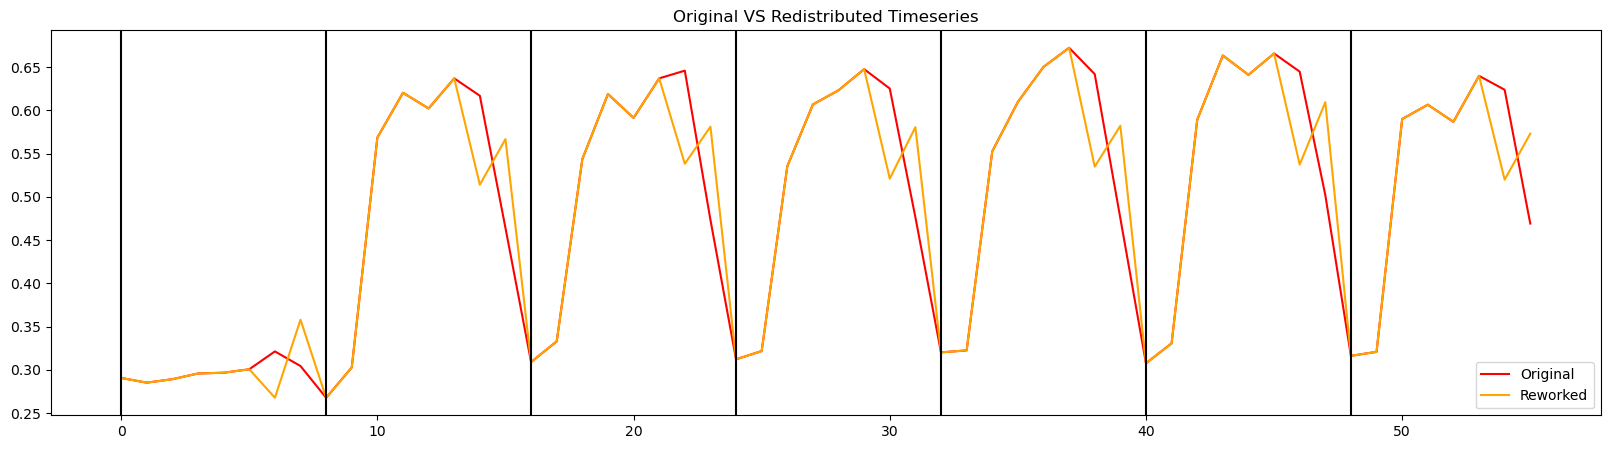

In [158]:
reworked_timeseries=[]
for i in range(0,len(timeseries2),8):
    redist=timeseries2[i+6]/6
    for j in range(0,8):
        reworked_timeseries.append(timeseries2[i+j])
    reworked_timeseries[i+6]=reworked_timeseries[i+6]-redist
    reworked_timeseries[i+7]=reworked_timeseries[i+7]+redist

plt.figure(figsize=(20,5))
plt.title('Original VS Redistributed Timeseries')
plt.plot(timeseries2[0:8*7],color='red',label='Original')
plt.plot(reworked_timeseries[0:8*7],color='orange',label='Reworked')
plt.legend()
for i in range(0,8*7,8):
    plt.axvline(x=i,color='black')
#plt.savefig('normalization')
plt.show()




[]

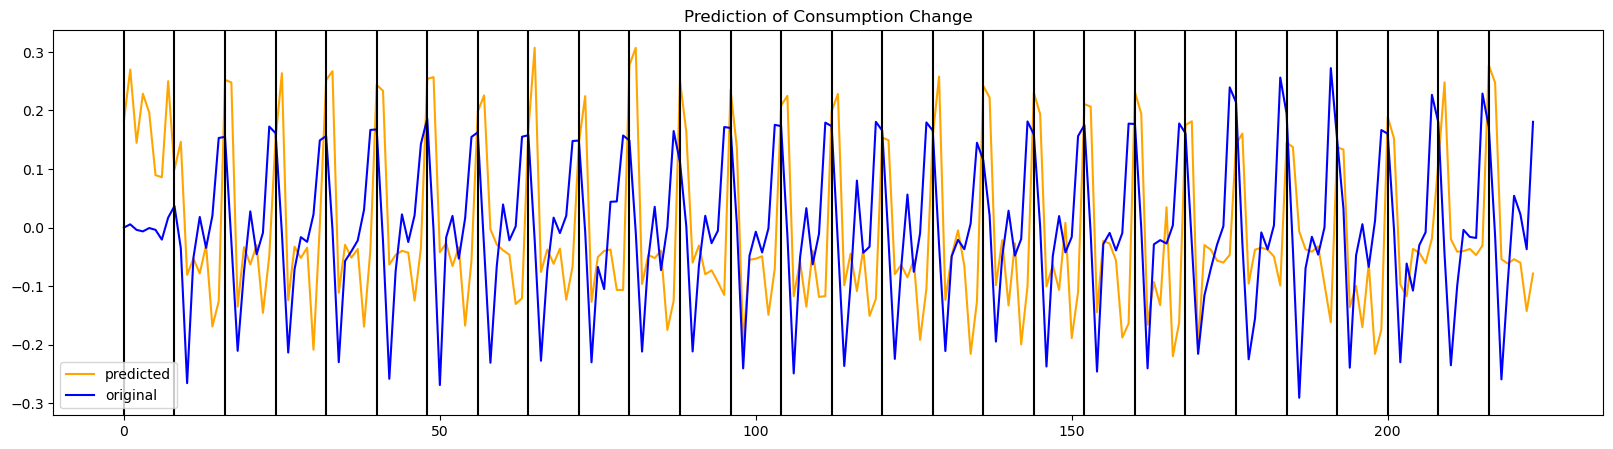

In [167]:
model=forest_models_short[7]
ypred=model.predict(reworked_timeseries)
yorig=[0]
for i in range(1,len(timeseries2)):
    yorig.append(timeseries2[i-1]-timeseries2[i])
clear_output()
plt.figure(figsize=(20,5))
plt.title('Prediction of Consumption Change')
plt.plot(ypred[0:8*7*4],color='orange',label='predicted')
plt.plot(yorig[0:8*7*4],color='blue',label='original')
for i in range(0,8*7*4,8):
    plt.axvline(x=i,color='black')
plt.legend()
#plt.savefig('prediction')
plt.plot()

In the above graph we can see the consumption within a day of the <b style='color:blue'>original model</b> and the <b style='color:orange'>predicted model</b><br>
We can see that in the original case the consumption rose within a day,but in the modified version of the timeseries the consumpion rises withing the morning and then gradualy drops within the day.